# Learning the expansion scalar
If you aren't warpin' space then you don't have a warp drive.

To quantify the warp some Warp Theorists have used the [expansion scalar](https://en.wikipedia.org/wiki/Raychaudhuri_equation#Intuitive_significance). [This paper is worth a read](https://arxiv.org/abs/2404.03095) if you don't know your warp theory already.

Let's find some metrics that warp space in a similar way to the granddaddy of all
warp metrics: [the Alcubierre metric](https://arxiv.org/pdf/gr-qc/0009013).

We'll do this by parameterizing a metric tensor with a CPPN and fitting its expansion scalar to that of Alcubierre. That should drive the solution towards having the prized warp bubble but we can impose other penalties on the search like minimizing energy density.

In [ ]:
# Install stuff if we're in colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install dm-haiku

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import haiku as hk
import optax
import matplotlib.pyplot as plt
from tqdm import tqdm


I found all of the basic building blocks for modeling relativity in JAX here: https://github.com/haimengzhao/relativity-jax

In [2]:
# Start from https://github.com/haimengzhao/relativity-jax

metric = lambda coords, model: model(coords)

pd_metric = jax.jacfwd(metric)

def christoffel(coords, model):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)
    partial_derivs = jnp.einsum('mns -> smn', pd_metric(coords, model))
    sum_partial_derivs = partial_derivs + jnp.einsum('nrm -> mnr', partial_derivs) - jnp.einsum('rmn -> mnr', partial_derivs)
    christ = 0.5 * jnp.einsum('sr, mnr -> smn', inv_met, sum_partial_derivs)
    return christ
pd_christoffel = jax.jacfwd(christoffel)


def riemann_curvature(coords, model):
    christ = christoffel(coords, model)
    pd_christ = jnp.einsum('rmns -> srmn', pd_christoffel(coords, model))
    return jnp.einsum('mrns -> rsmn', pd_christ) - jnp.einsum('nrms -> rsmn', pd_christ) + jnp.einsum('rml, lns -> rsmn', christ, christ) - jnp.einsum('rnl, lms -> rsmn', christ, christ)


def ricci_tensor(coords, model):
    riemann = riemann_curvature(coords, model)
    return jnp.einsum('rsru -> su', riemann)


def ricci_scalar(coords, model):
    return jnp.einsum('mn, mn -> ', jnp.linalg.inv(metric(coords, model)), ricci_tensor(coords, model))


def einstein_tensor(coords, model):
    met = metric(coords, model)
    ricci_ts = ricci_tensor(coords, model)
    return ricci_ts - 0.5 * jnp.einsum('mn, mn -> ', jnp.linalg.inv(met), ricci_ts).reshape(1, 1) * met

# End https://github.com/haimengzhao/relativity-jax

The Alcubierre metric. We're going to target its warp effects but with different energy configurations.

In [3]:
# Alcubierre metric parameters
v_s = 0.5  # Warp bubble velocity
sigma = 3  # Steepness of the bubble's edge
R = 1  # Radius of the bubble

def alcubierre_metric(coords):
    t, x, y, z = coords
    r_s = jnp.sqrt((x - v_s * t)**2 + y**2 + z**2)
    f_rs = (jnp.tanh(sigma * (r_s + R)) - jnp.tanh(sigma * (r_s - R))) / (2 * jnp.tanh(sigma * R))

    v2 = 0.1**2
    f2 = f_rs**2

    g = jnp.array([
        [-1 + v2 * f2, -v_s * f2, 0, 0],
        [-v_s * f2, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return g

How much are we warping? The expansion scalar knows. We'll also need to know the energy density.

In [18]:
def expansion_scalar(model, coords):
    met = metric(coords, model)
    inv_met = jnp.linalg.inv(met)

    pd_met = pd_metric(coords, model)
    trace_extrinsic_curvature = jnp.einsum('mnm -> n', pd_met)

    # Calculate the expansion scalar
    theta = jnp.einsum('mn, n -> ', inv_met, trace_extrinsic_curvature)

    return theta

def stress_energy_tensor(model, coords):
    G = einstein_tensor(coords, model)
    T = G / (jnp.pi * 8)
    return T

def energy_density(model, coords):
    return stress_energy_tensor(model, coords)[0, 0]


Just need some plotting code and then it's warping time.

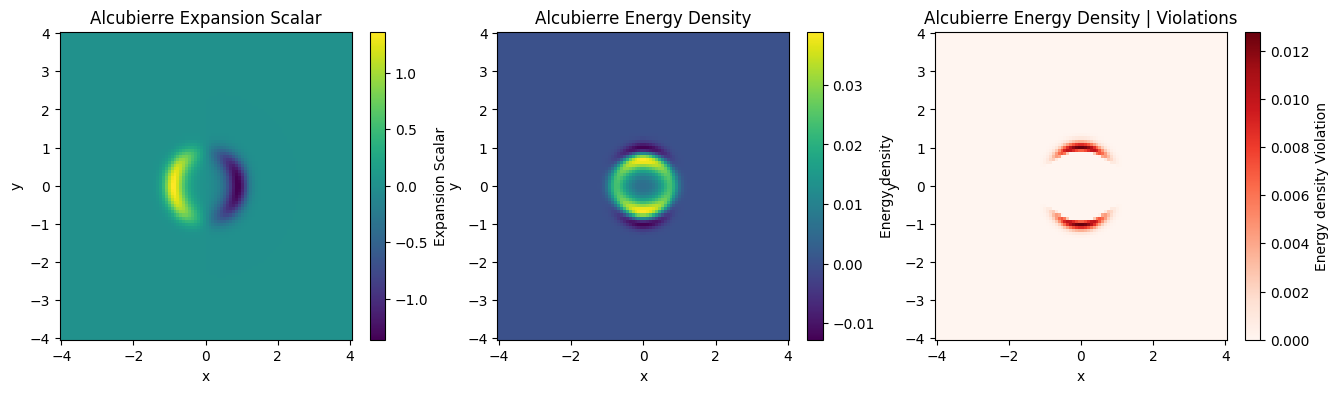

In [19]:
# Mostly generated by chatgpt, thanks
def plot_expansion(f_metric, title='Expansion Scalar', w=3, n=100, quantile=None):
    # Vectorized expansion scalar function using jax.vmap
    vectorized_expansion_scalar = jax.vmap(partial(expansion_scalar, f_metric), in_axes=(0,))

    # Generate grid points for the plot
    x_values = jnp.linspace(-w, w, n)
    y_values = jnp.linspace(-w, w, n)

    # Create mesh grids for the coordinates
    X, Y = jnp.meshgrid(y_values, x_values, indexing='ij')

    # Expand dimensions for broadcasting
    Y_flat = Y.flatten()
    X_flat = X.flatten()
    Z_flat = jnp.zeros_like(X_flat)  # z = 0 for all points
    T_flat = jnp.zeros_like(X_flat)  # t = 0 for all points
    # Combine into a single array of coordinates
    coords_flat = jnp.stack([T_flat, X_flat, Y_flat, Z_flat], axis=-1)
    # Compute the expansion scalar over the entire grid using vectorized function
    expansion_values_flat = vectorized_expansion_scalar(coords_flat)
    expansion_values_flat = expansion_values_flat.at[jnp.isnan(expansion_values_flat)].set(0)
    # Clamp extreme values:
    if quantile is not None:
        qs = jnp.quantile(jnp.abs(expansion_values_flat), quantile)
        expansion_values_flat = expansion_values_flat.clip(-qs, qs)

    # Reshape back to match the grid shape
    expansion_values = jnp.reshape(expansion_values_flat, X.shape)
    # Plot the expansion scalar
    plt.pcolormesh(X, Y, expansion_values, cmap='viridis', shading='auto')
    plt.colorbar(label='Expansion Scalar')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

def plot_energy(f_metric, title='Energy Density', w=3, n=100, quantile=None):
    # Vectorized expansion scalar function using jax.vmap
    vectorized_energy_density = jax.jit(jax.vmap(partial(energy_density, f_metric), in_axes=(0,)))

    # Generate grid points for the plot
    x_values = jnp.linspace(-w, w, n)
    y_values = jnp.linspace(-w, w, n)

    # Create mesh grids for the coordinates
    X, Y = jnp.meshgrid(x_values, y_values, indexing='ij')

    # Expand dimensions for broadcasting
    Y_flat = Y.flatten()
    X_flat = X.flatten()
    Z_flat = jnp.zeros_like(X_flat)  # z = 0 for all points
    T_flat = jnp.zeros_like(X_flat)  # t = 0 for all points
    # Combine into a single array of coordinates
    coords_flat = jnp.stack([T_flat, X_flat, Y_flat, Z_flat], axis=-1)
    # Compute the expansion scalar over the entire grid using vectorized function
    expansion_values_flat = vectorized_energy_density(coords_flat)
    expansion_values_flat = expansion_values_flat.at[jnp.isnan(expansion_values_flat)].set(0)
    # Clamp extreme values:
    if quantile is not None:
        qs = jnp.quantile(jnp.abs(expansion_values_flat), quantile)
        expansion_values_flat = expansion_values_flat.clip(-qs, qs)

    # Reshape back to match the grid shape
    expansion_values = jnp.reshape(expansion_values_flat, X.shape)
    # Plot the expansion scalar
    plt.subplot(1, 3, 2)
    plt.pcolormesh(X, Y, expansion_values, cmap='viridis', shading='auto')
    plt.colorbar(label='Energy density')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)

    plt.subplot(1, 3, 3)
    plt.pcolormesh(X, Y, jnp.abs(expansion_values.clip(None, 0)), cmap='Reds', shading='auto')
    plt.colorbar(label='Energy density Violation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title + ' | Violations')

def make_plots(f_metric, title='', w=3, n=100, quantile=None):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plot_expansion(f_metric, title=title + ' Expansion Scalar', w=w, n=n, quantile=quantile)
    plot_energy(f_metric, title=title + ' Energy Density', w=w, n=n, quantile=quantile)

make_plots(alcubierre_metric, title='Alcubierre', w=4)
plt.show()


Moving in the x axis, you can see by the expansion scalar plot that space expands on one side and contracts on the other. That's how we warp around. But you can see the energy density goes negative which isn't something we can do at our current level of technology.

# Model
Let's make a compositional pattern producing network (CPPN) that models the mapping from (t,x,y,z) to a metric tensor.
Choosing how to parameterize the metric is important--there are many bad choices if you're looking at any ol' random matrix.

In [6]:
num_model_inputs = 4
num_model_outputs = 2
# Define the neural network that outputs the components of the metric tensor
def cppn_model(coords):
    # gelu and cos seem to work
    hidden_activation = jnp.cos  # jax.nn.gelu  # jnp.tanh # jax.nn.gelu  #
    # tanh or identity have been ok here. remember this value should make sense in the metric tensor
    output_activation = jnp.tanh  #  lambda x: x  #
    net = hk.Sequential([
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(256), hidden_activation,
        hk.Linear(num_model_outputs, w_init=jnp.zeros, b_init=jnp.zeros),
        output_activation,
    ])
    return net(coords)

# Transform the model
cppn_init, cppn_apply = hk.transform(cppn_model)

def perturb_minkowski(params, coords):
    """
    Gets the metric params from the nn model and adds them to the Minkowski metric.
    In this case we want to find metrics where there's movement so we explore
    terms in dt^2 and dxdt
    """
    # Add radial component to coords
    # coords = jnp.concatenate([coords, jnp.sum(coords ** 2, keepdims=True)], axis=-1)
    g_values = cppn_apply(params, None, coords)
    eps = 1e-5
    dm = jnp.array([
        [g_values[0], g_values[1], 0, 0],
        [g_values[1], 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
    ])
    minkowski = jnp.eye(4)
    minkowski.at[0, 0].set(-1.)
    # fall off over distance to prevent hacking the metric in unregulated areas
    # r = jnp.sqrt(jnp.sum(coords ** 2))
    # dm = dm / (1 + r)
    g = minkowski + dm
    # make sure the overall signature is spacetimey?
    g.at[0, 0].set(-jnp.abs(g[0, 0]) - eps)
    g.at[1, 1].set(jnp.abs(g[1, 1]) + eps)
    return g

f_metric = perturb_minkowski

# Fit the model
Sample batches of random points and fit the corresponding expansion scalars from the CPPN metric to the Alcubierre metric at that point:

```MSE(expansion(CPPN(x)), expansion(Alcubierre(x)))```

Also add some constraints on the stress-energy tensor to penalize negative energy density and also try to minimize the energy.

```max(0, -energy_density(x)) + energy_density(x) ** 2```

So full loss function is:

```MSE(expansion(CPPN(x)), expansion(Alcubierre(x))) + max(0, -energy_density(x)) + energy_density(x) ** 2```

There are adjustable weights for these loss terms. Zero out all energy penalties to only fit the expansion scalar.

Training loop running...


Elapsed: 00:09 | 1 at  9.68s/it, loss=7.4824646e-05

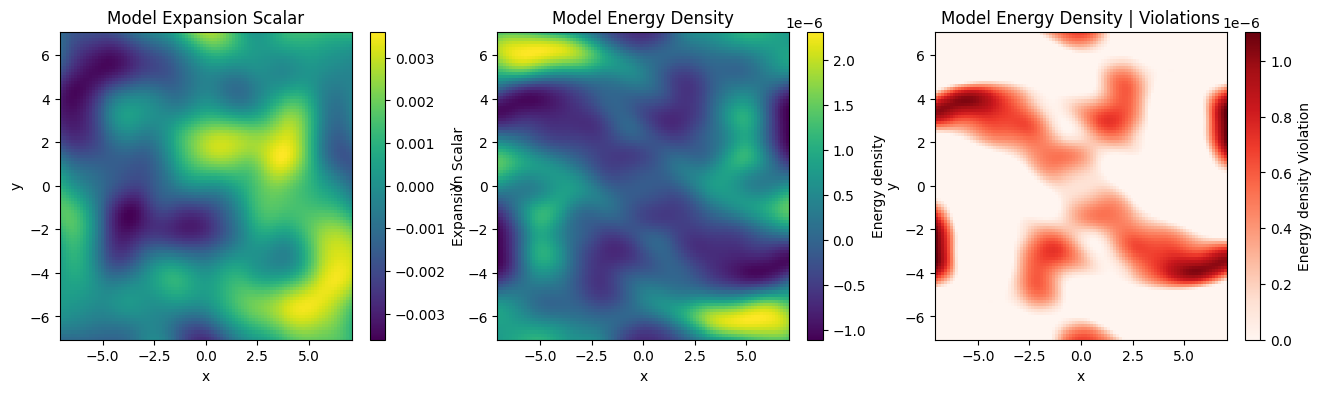

Elapsed: 00:21 | 11 at  1.00s/it, loss=0.0009524664

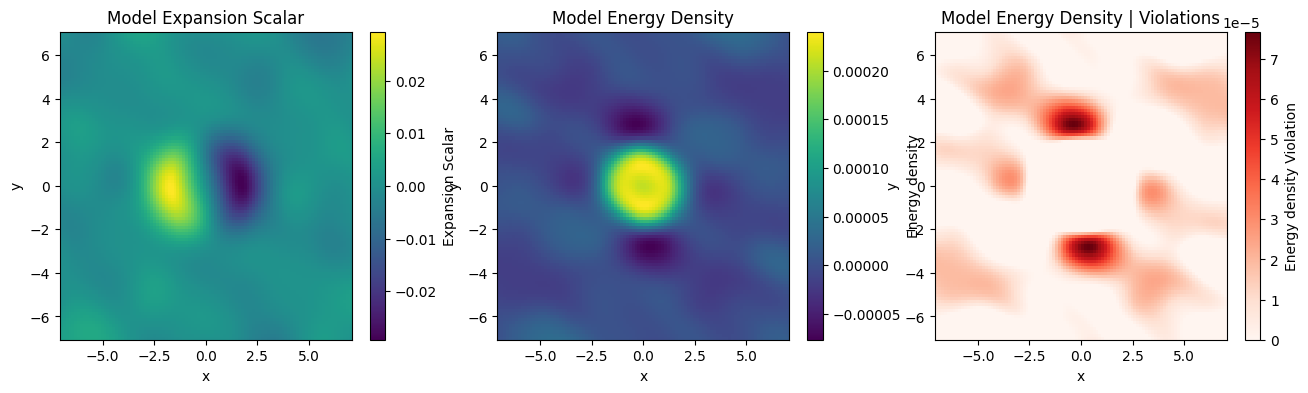

Elapsed: 00:33 | 21 at  1.11it/s, loss=0.0009831982 

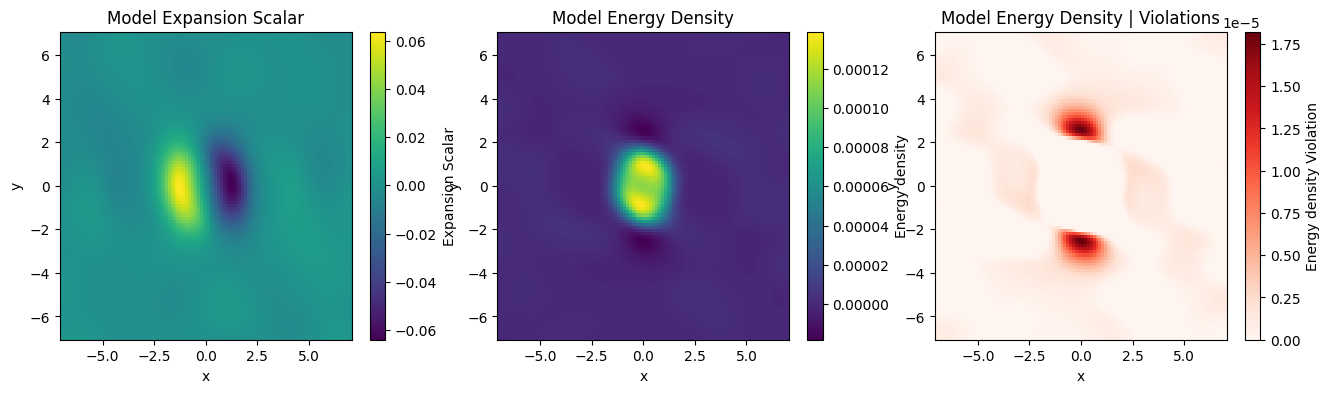

Elapsed: 00:45 | 31 at  1.10it/s, loss=0.00074159936

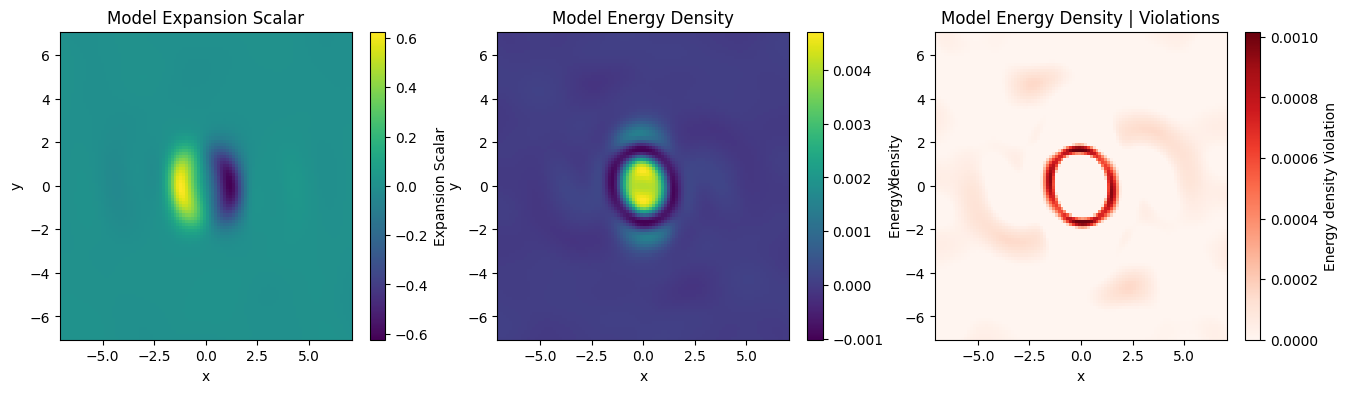

Elapsed: 00:56 | 41 at  1.08it/s, loss=0.0012044039 

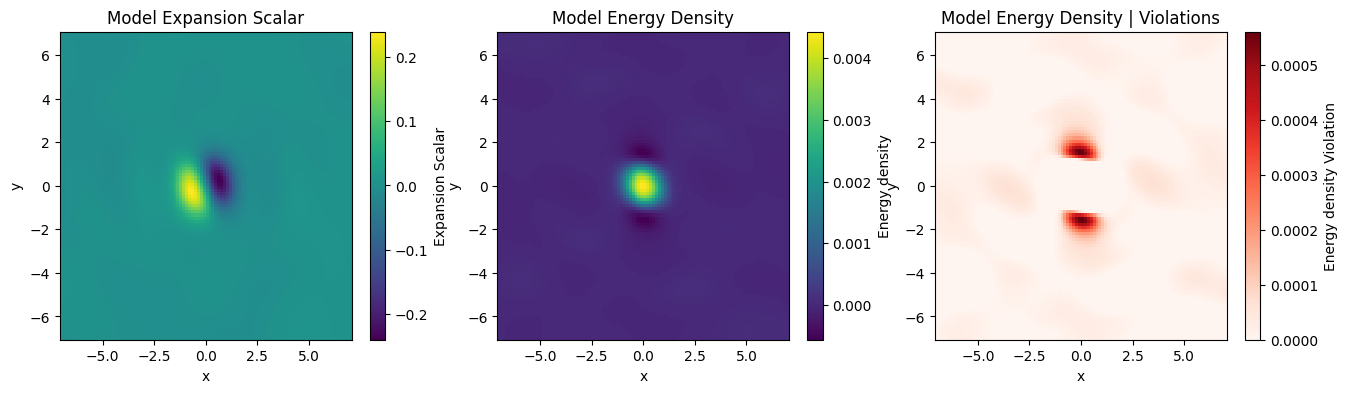

Elapsed: 01:07 | 51 at  1.11it/s, loss=0.0022847715 

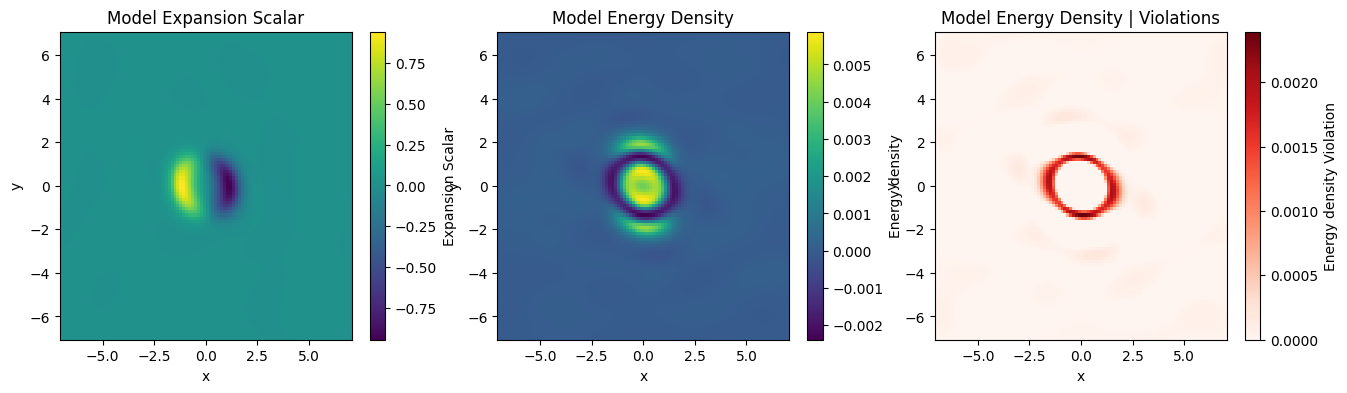

Elapsed: 01:19 | 61 at  1.06it/s, loss=0.0007039782 

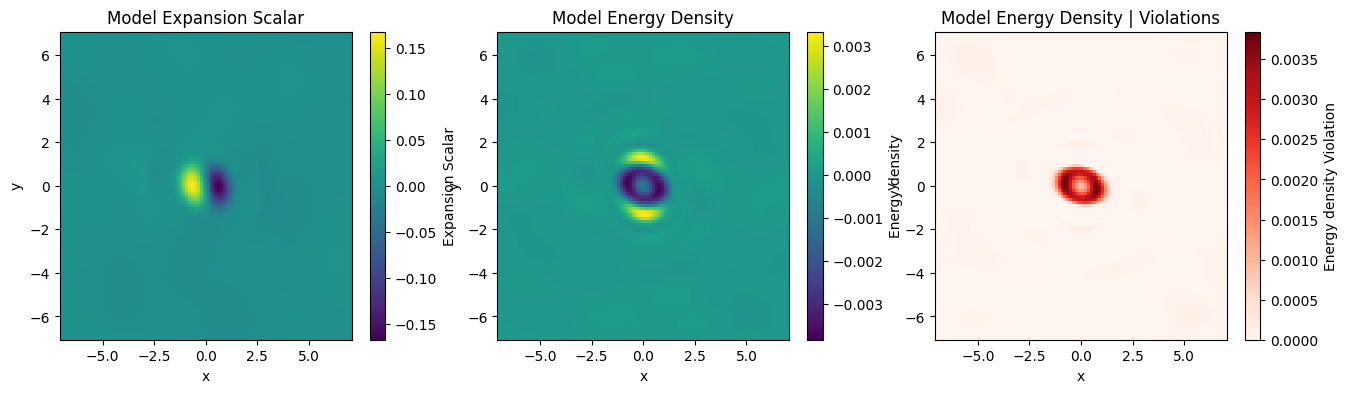

Elapsed: 01:30 | 71 at  1.11it/s, loss=0.0006828931

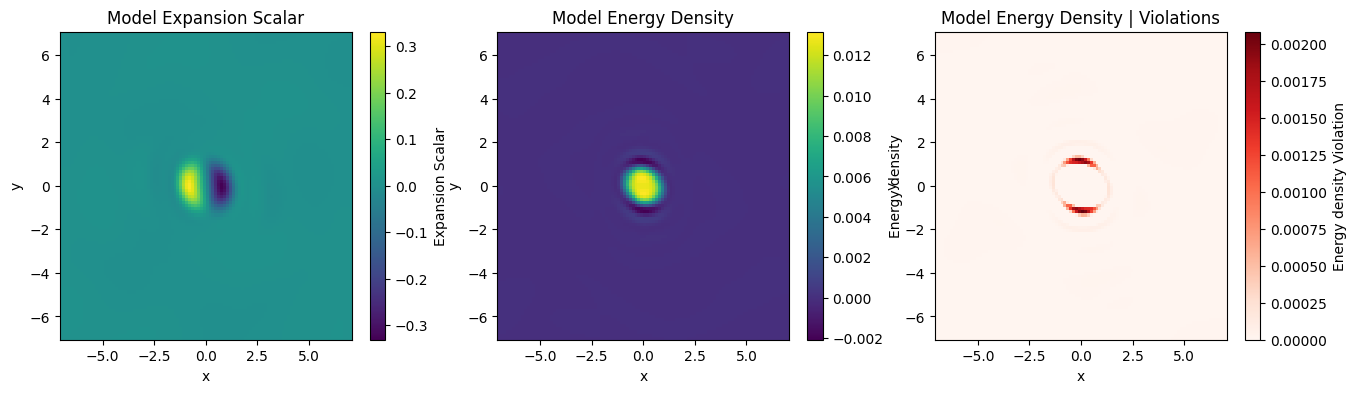

Elapsed: 01:42 | 81 at  1.11it/s, loss=0.0010418313

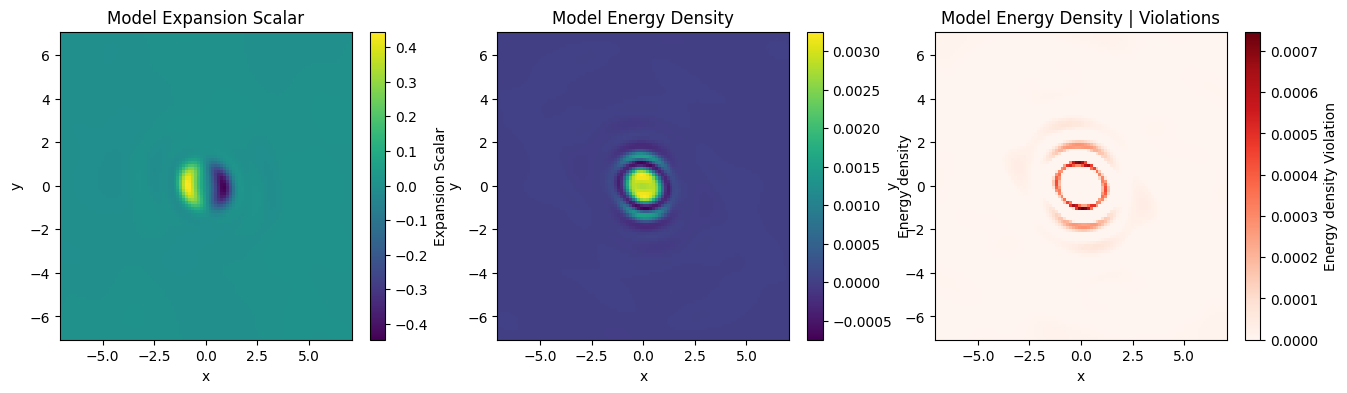

Elapsed: 01:53 | 91 at  1.13it/s, loss=0.0005310482

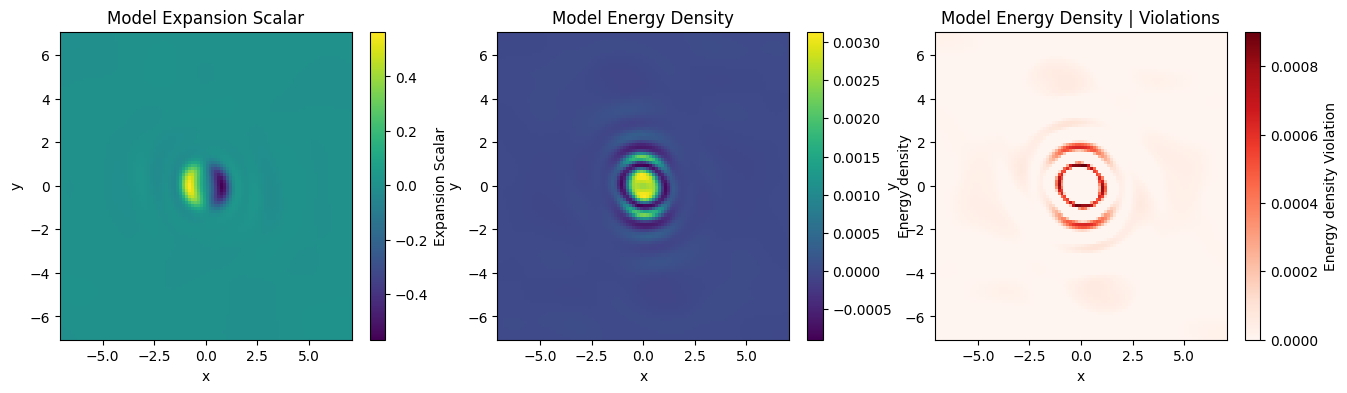

Elapsed: 02:04 | 101 at  1.13it/s, loss=8.197827e-05 

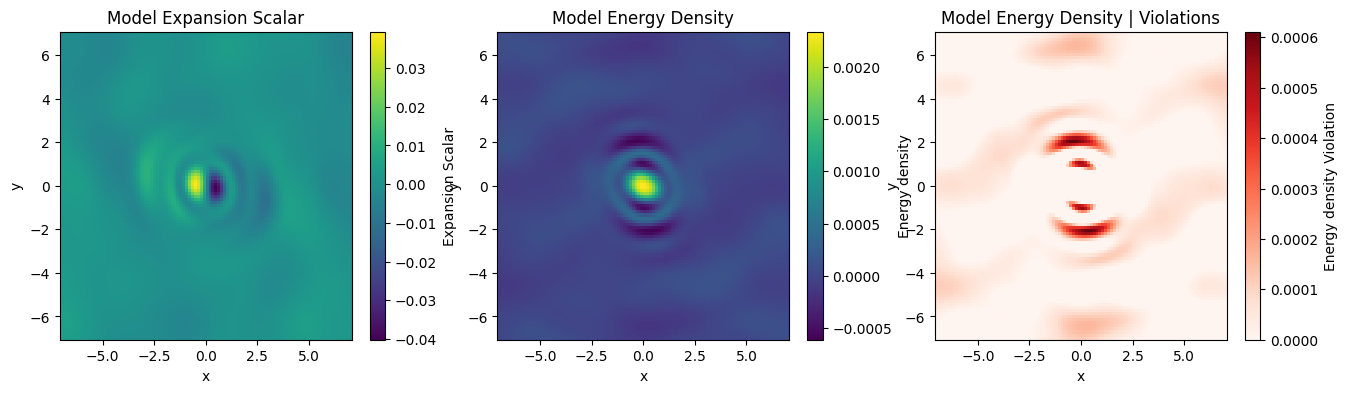

Elapsed: 02:15 | 111 at  1.11it/s, loss=0.00015721231

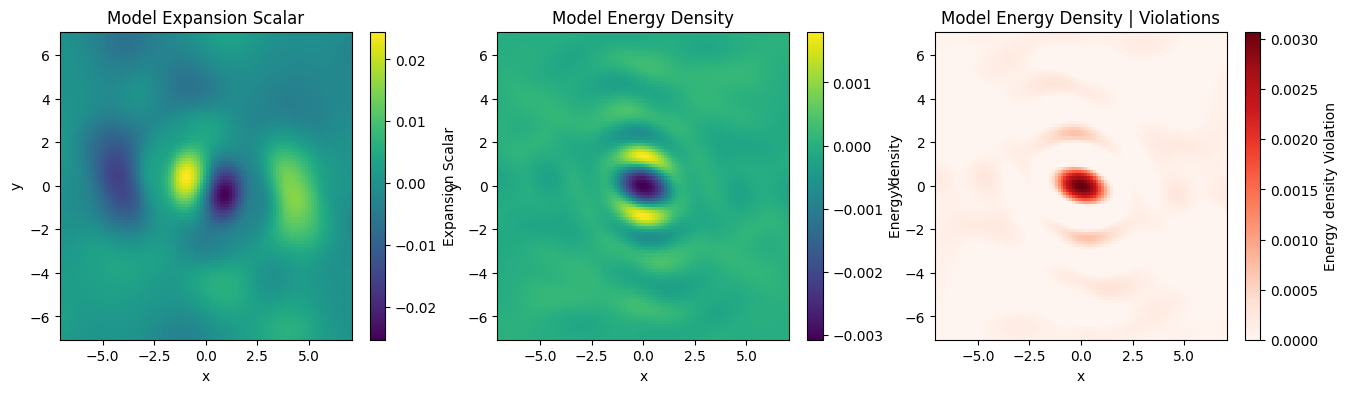

Elapsed: 02:27 | 121 at  1.14s/it, loss=0.0011199998 

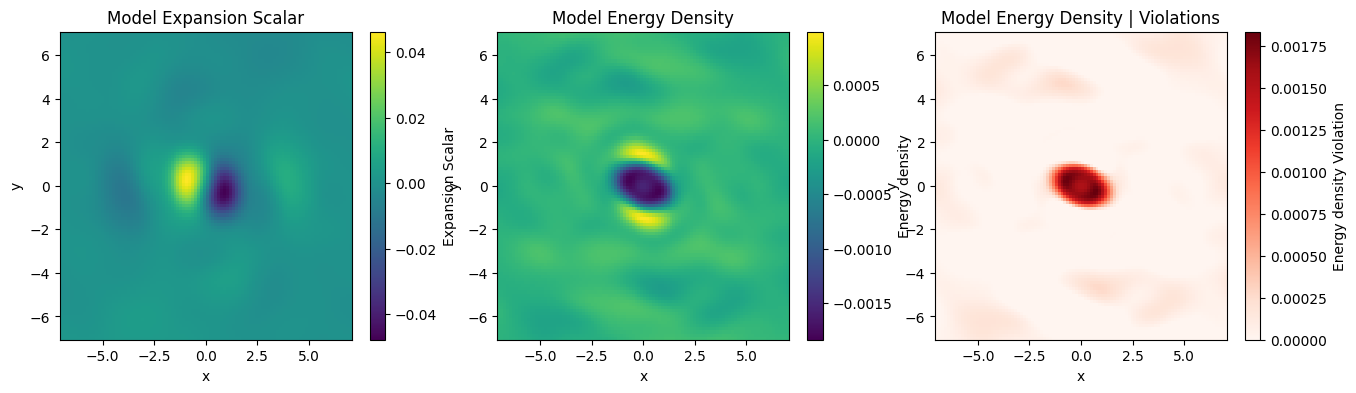

Elapsed: 02:39 | 131 at  1.10it/s, loss=0.0015015898

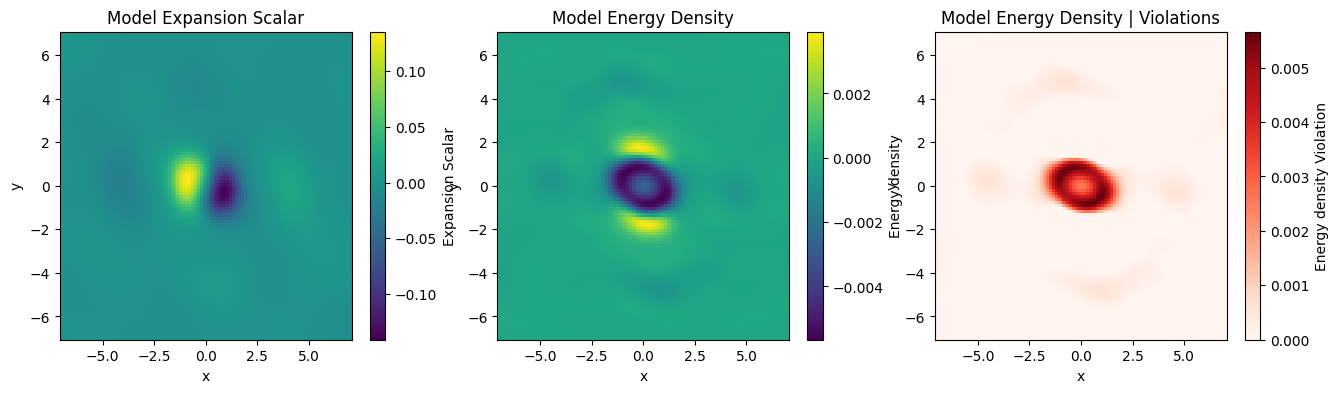

Elapsed: 02:51 | 141 at  1.10it/s, loss=0.0005802399 

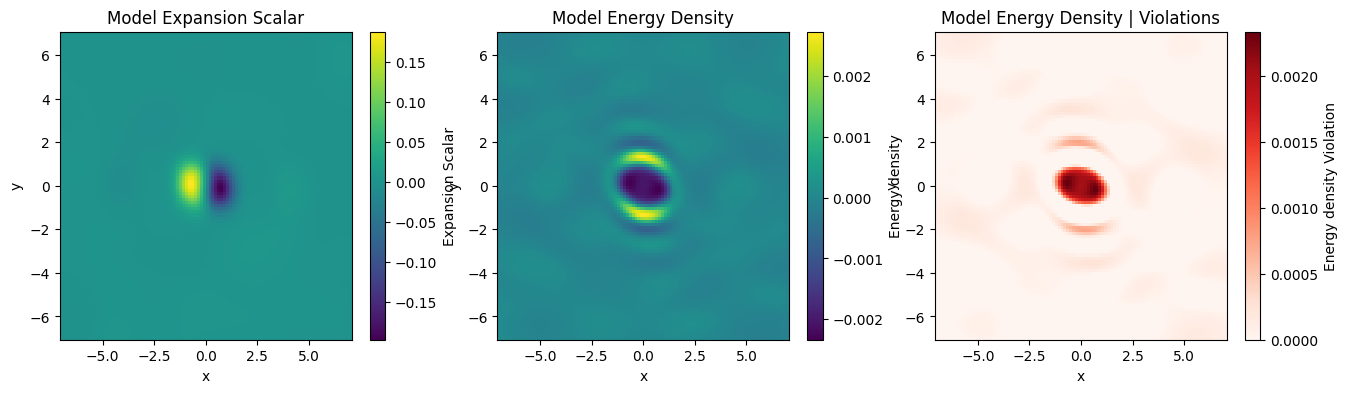

Elapsed: 03:02 | 151 at  1.11it/s, loss=0.00032322365

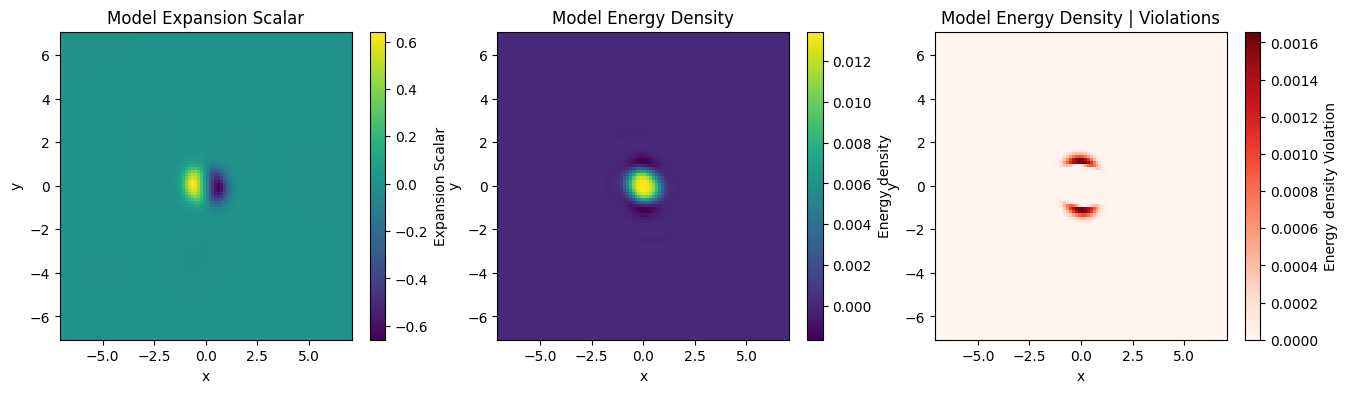

Elapsed: 03:16 | 161 at  1.05s/it, loss=0.00061832037

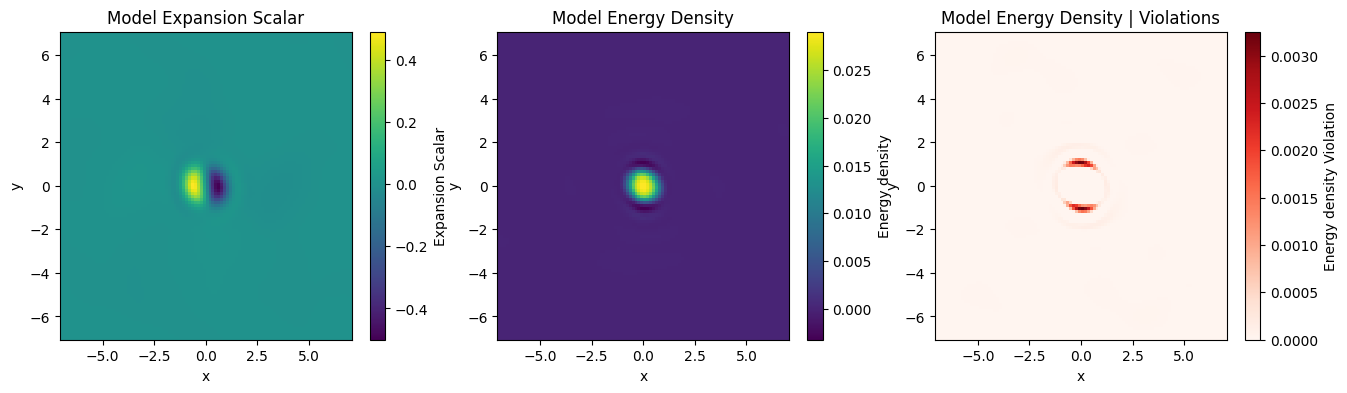

Elapsed: 03:26 | 167 at  1.24s/it, loss=0.00019670253

interrupting training...


In [15]:
sample_radius = 5
batch_size = 1000
num_steps = 1_000_000
plot_every = 10
save_plots = False
plots_path = './frames/step_{step}.png'
display_plots = True
negative_energy_penalty = 1.  # minimize negative energy density
energy_density_penalty = 0.5  # minimize energy density
energy_compactness_penalty = 0.
T_l2_penalty = 0  # 1.
l2_penalty = 0. # 1e-5
learning_rate = 1e-3

def single_loss_function(f_metric, params, coords):
    f_metric = partial(f_metric, params)
    # Warp loss - fit to the expansion scalar
    model_expansion = expansion_scalar(f_metric, coords)
    alcubierre_expansion = expansion_scalar(alcubierre_metric, coords)
    loss = (model_expansion - alcubierre_expansion) ** 2

    # Stress-energy losses
    T = stress_energy_tensor(f_metric, coords)
    energy_density_x = T[0, 0]
    if T_l2_penalty:
        loss += T_l2_penalty * (T ** 2).sum()
    if negative_energy_penalty:
        loss += negative_energy_penalty * jnp.maximum(0., -energy_density_x)  # penalize negative energy, brother
    if energy_density_penalty:
        loss += energy_density_penalty * energy_density_x ** 2  # minimize energy density
    if energy_compactness_penalty:
        # encourage the solution to not have weird spacetime outside of our sampling region
        # by heavily weighting energy density loss by radius
        r2 = jnp.sum(coords ** 2)
        loss += energy_compactness_penalty * (energy_density_x * r2) ** 2

    return loss

# Vectorize the single loss function
vectorized_loss_function = jax.jit(jax.vmap(partial(single_loss_function, f_metric), in_axes=(None, 0)))

# Define the full loss function over a batch
@jax.jit
def loss_function(params, batch):
    batch = jnp.array(batch)  # Ensure batch is a proper array
    losses = vectorized_loss_function(params, batch)
    # good_losses = losses.at[jnp.isnan(losses)].set(0)
    good_losses = losses
    loss = jnp.mean(good_losses)
    # Add L2 regularization term
    if l2_penalty:
        loss = loss + sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)) * l2_penalty
    return loss

# Initialize the neural network parameters
rng = jax.random.PRNGKey(42)
params = cppn_init(rng, jnp.zeros(num_model_inputs))

# Define the optimizer
# optimizer = optax.apply_if_finite(optax.adam(learning_rate), 10)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Function to update the parameters
def update(params, opt_state, batch):
    grads = jax.grad(loss_function)(params, batch)
    grads = jax.tree.map(lambda g: jnp.clip(g, -1.0, 1.0), grads)  # Gradient clipping
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

print('Training loop running...')
rng, batch_rng = jax.random.split(rng)

try:
    with tqdm(
        bar_format="Elapsed: {elapsed} | {n_fmt} at {rate_fmt}{postfix}",
    ) as t:
        for step in range(num_steps):
            # take random samples of the space
            batch_rng, subkey = jax.random.split(batch_rng)
            #batch = jax.random.uniform(subkey, shape=(batch_size, 4), minval=-sample_radius, maxval=sample_radius)
            batch = jax.random.normal(subkey, shape=(batch_size, 4)) * sample_radius
            params, opt_state = update(params, opt_state, batch)

            if step % 5 == 0:
                current_loss = loss_function(params, batch)
                if jnp.isnan(current_loss):
                    print("NaN detected in loss, stopping training.")
                    break
                t.set_postfix(loss=current_loss)
            t.update()
            if step % plot_every == 0:
                make_plots(partial(f_metric, params), title='Model', w=int(sample_radius * 1.5))
                if save_plots:
                    padded_steps = str(step).zfill(6)
                    plt.savefig(plots_path.format(step=padded_steps))
                if display_plots:
                    plt.show()
                plt.close()
except KeyboardInterrupt:
    print('interrupting training...')



Let's see how it generalizes farther out.

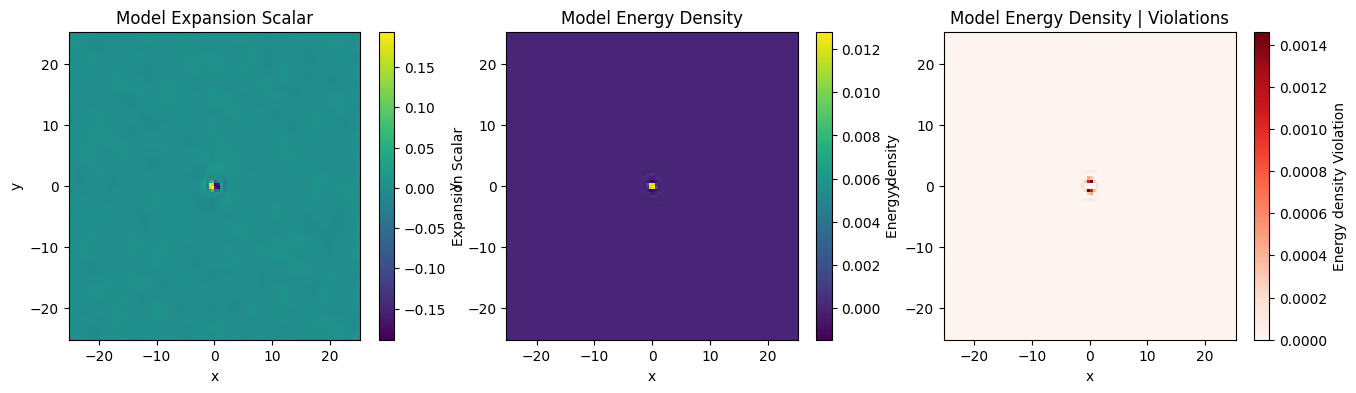

In [17]:
make_plots(partial(f_metric, params), title='Model', w=sample_radius * 5, n=100)
